In [12]:
import pandas as pd

In [13]:
df = pd.read_csv(r'/content/NYC_NEW.csv')

In [14]:
df.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'snowfall', 'wind_speed_10m',
       'wind_gusts_10m'],
      dtype='object')

In [15]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import requests
import os

In [16]:
df.drop(columns=['date'],inplace=True)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
R2 Score: 0.15350813490935167


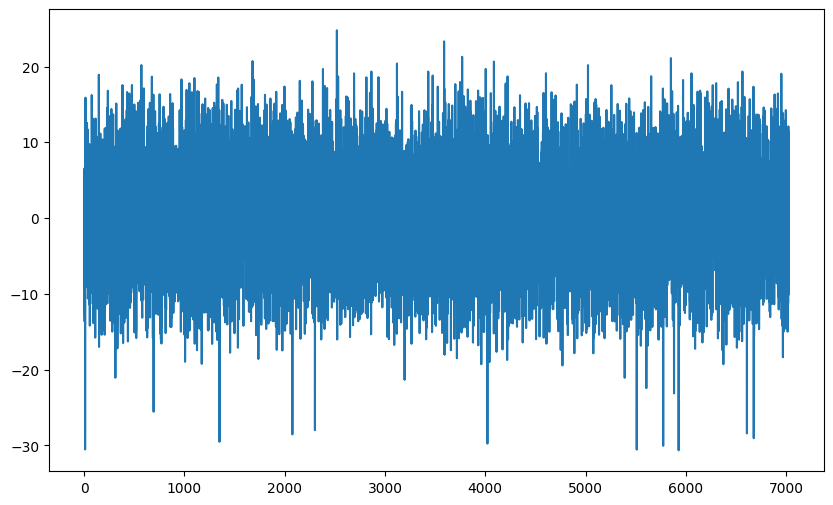

SVR(C=1)


In [17]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


X = df[['relative_humidity_2m', 'precipitation', 'rain', 'snowfall', 'wind_speed_10m', 'wind_gusts_10m']]
y = df['temperature_2m']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

svr_regr = SVR()
param_grid_svr = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.01, 0.1, 1],
        'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1]
    }

grid_search_svr = GridSearchCV(svr_regr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search_svr.fit(X_train_scaled, y_train_scaled)
best_svr_regr = grid_search_svr.best_estimator_

y_pred_scaled = best_svr_regr.predict(X_train_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
r2 = r2_score(y_train, y_pred)
print("R2 Score:", r2)

l = []
for i in range(0,len(y_pred_scaled)):
  l.append(i)


plt.figure(figsize=(10, 6))
plt.plot(l,y_train-y_pred)
plt.show()
print(best_svr_regr)

In [27]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", "wind_speed_10m", "wind_gusts_10m"],
	"daily": "temperature_2m_max",
	"start_date": "2024-04-04",
	"end_date": "2024-04-04"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates 52.52000045776367°N 13.419998168945312°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                        date  temperature_2m  relative_humidity_2m  \
0  2024-04-04 00:00:00+00:00       10.045500                  89.0   
1  2024-04-04 01:00:00+00:00        9.945499                  88.0   
2  2024-04-04 02:00:00+00:00        9.695499                  90.0   
3  2024-04-04 03:00:00+00:00        9.745500                  93.0   
4  2024-04-04 04:00:00+00:00        9.295500                  94.0   
5  2024-04-04 05:00:00+00:00        9.045500                  91.0   
6  2024-04-04 06:00:00+00:00        9.395500                  90.0   
7  2024-04-04 07:00:00+00:00       10.745500                  83.0   
8  2024-04-04 08:00:00+00:00       12.145500                  73.0   
9  2024-04-04 09:00:00+00:00       13.695499                  63.0   
10 2024-04-04 10:00:00+00:00       13.445499                  67.0   
11 2024-04-04 11:00:00+00:00      

In [28]:
import pandas as pd
data = {'max_temp': []}
output = pd.DataFrame(data)

In [30]:
import numpy as np
# Iterate over each row in hourly_dataframe
for index, row in hourly_dataframe.iterrows():

    relative_humidity_2m = row['relative_humidity_2m']
    precipitation = row['precipitation']
    rain = row['rain']
    snowfall = row['snowfall']
    wind_speed_10m = row['wind_speed_10m']
    wind_gusts_10m = row['wind_gusts_10m']

    input_data = np.array([[relative_humidity_2m, precipitation, rain, snowfall, wind_speed_10m, wind_gusts_10m]])
    scale_input = scaler_X.transform(input_data)
    reshaped_input_data = scale_input.reshape((1, -1))
    predicted_output = best_svr_regr.predict(reshaped_input_data)
    predicted_output = scaler_y.inverse_transform(predicted_output.reshape(-1, 1)).ravel()
    output.at[index, 'max_temp'] = predicted_output[0]
print(output)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScal

     max_temp
0   14.004483
1   16.552085
2   15.218665
3   13.563480
4   13.207365
5   13.798720
6   13.995041
7   14.505288
8   14.430300
9   18.522606
10  20.154894
11  17.990585
12  16.939507
13  22.871918
14  19.519400
15  20.385827
16  18.584264
17  22.889213
18  20.456991
19  21.983690
20  14.724350
21  16.677900
22  16.644743
23  15.879869


Here We take the max value of the temperature we obtained from our prediction

In [31]:
max_temp_max = output['max_temp'].max()

The next cell is the actual max temp recorded today obtained from the weather api

In [32]:
daily_dataframe.temperature_2m_max[0]

14.445499

In [33]:
a=daily_dataframe.temperature_2m_max[0]
a=(a*9/5)+32
b=max_temp_max
c=(max_temp_max*9/5)+32
Offset_temp = max_temp_max-daily_dataframe.temperature_2m_max[0]
print("Offset_temp in Celsius is",b-daily_dataframe.temperature_2m_max[0])
print("Offset Temp in Farenheit is",c-a)

Offset_temp in Celsius is 8.44371375336857
Offset Temp in Farenheit is 15.198684756063429


 **Offset Temp mean how off the predicted values are from the actual values*

In [34]:
print(max_temp_max,"This is in Degree Celsius(Predicted)")
max_temp_max=(max_temp_max * 9/5) + 32
print(max_temp_max,"This is in Farenheit(Predicted)")

22.889213173534586 This is in Degree Celsius(Predicted)
73.20058371236226 This is in Farenheit(Predicted)


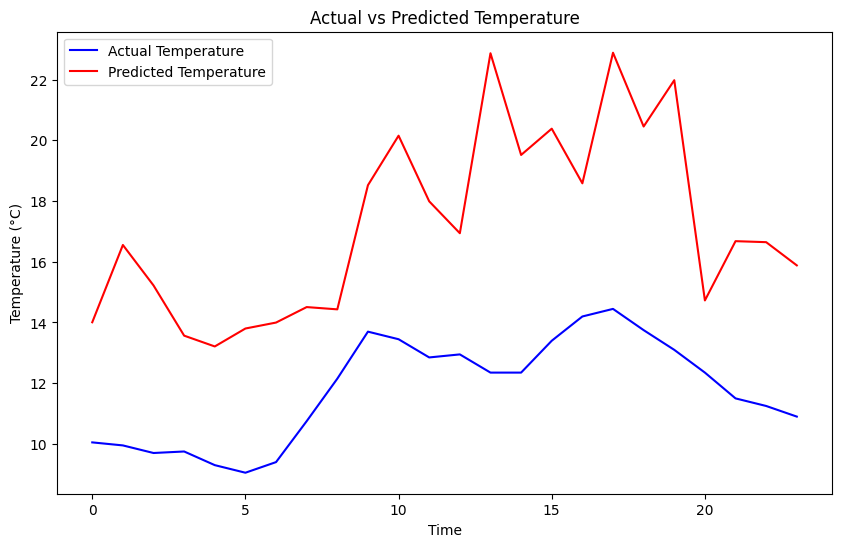

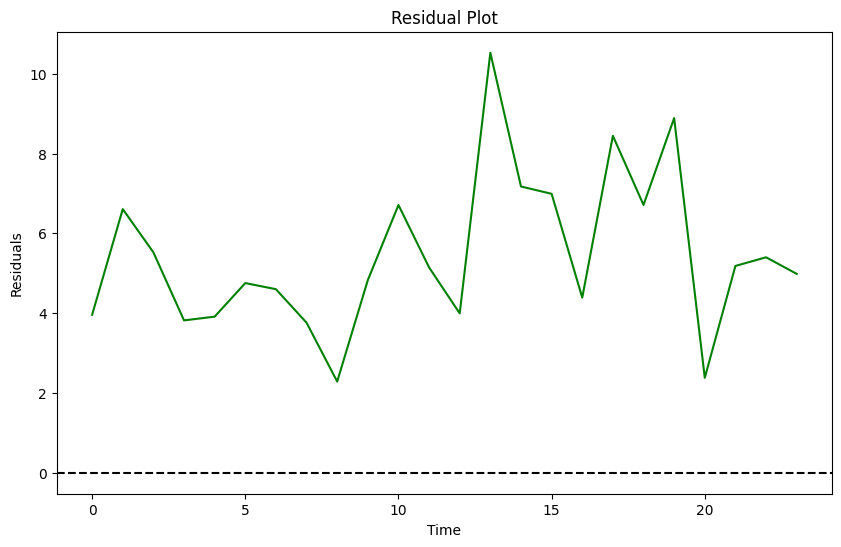

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourly_dataframe.index, hourly_dataframe['temperature_2m'], label='Actual Temperature', color='blue')
plt.plot(hourly_dataframe.index, output['max_temp'], label='Predicted Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()

residuals = output['max_temp'] - hourly_dataframe['temperature_2m']

plt.figure(figsize=(10, 6))
plt.plot(hourly_dataframe.index, residuals, color='green')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

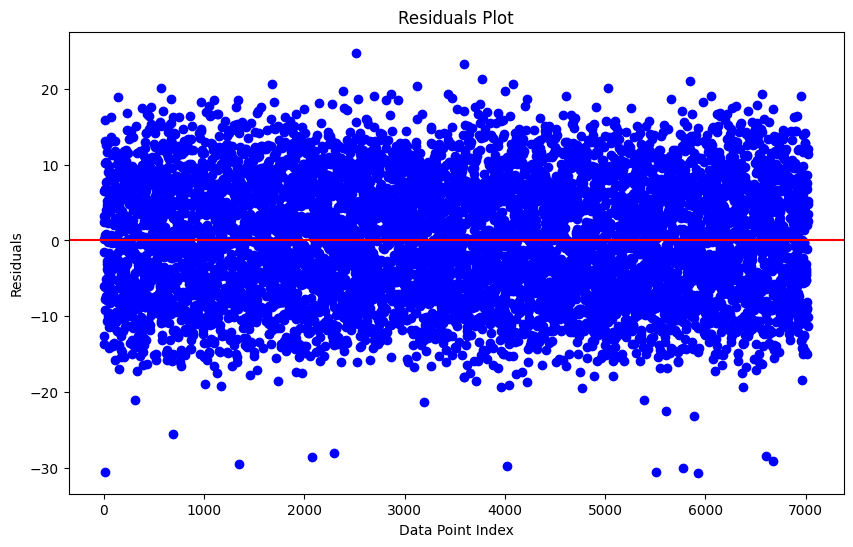

In [35]:
import matplotlib.pyplot as plt

residuals = y_train - y_pred


plt.figure(figsize=(10, 6))
plt.scatter(l, residuals, color='blue')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals Plot')
plt.xlabel('Data Point Index')
plt.ylabel('Residuals')
plt.show()


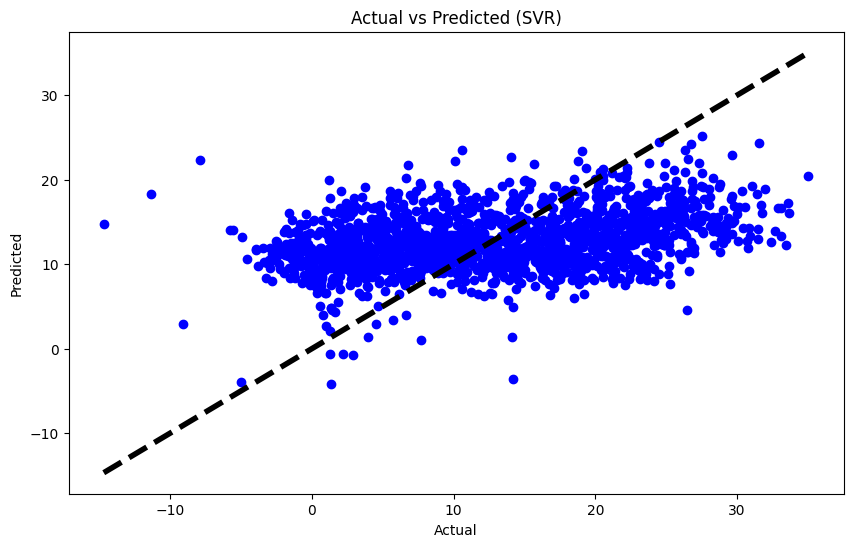

In [36]:

y_pred_test_scaled = best_svr_regr.predict(X_test_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (SVR)')
plt.show()


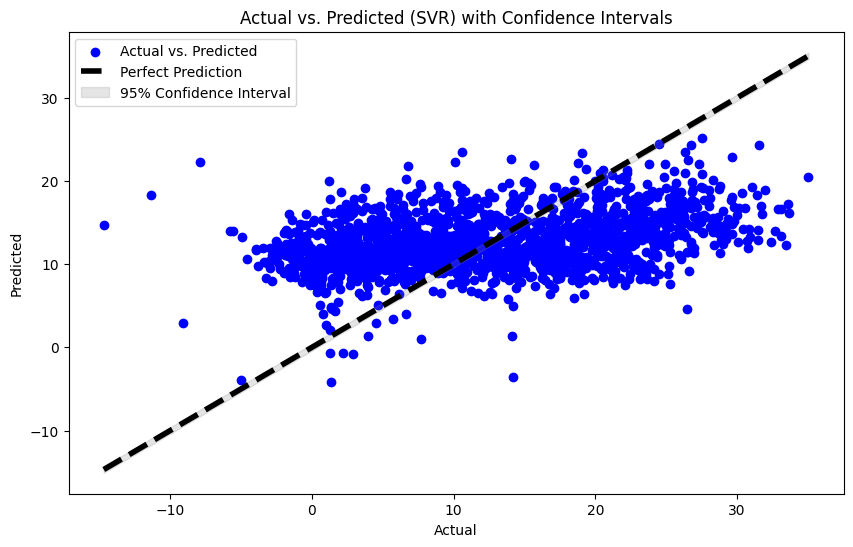

In [41]:

import numpy as np
from scipy import stats
confidence = 0.95
mse = mean_squared_error(y_test, y_pred_test)
n = len(y_test)
std_error = np.sqrt(mse / n)
z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
margin_of_error = z_score * std_error

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, label='Perfect Prediction')
plt.fill_between([y_test.min(), y_test.max()], [y_test.min() - margin_of_error, y_test.max() - margin_of_error],
                 [y_test.min() + margin_of_error, y_test.max() + margin_of_error], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (SVR) with Confidence Intervals')
plt.legend()
plt.show()
